In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
# Define transformations to apply to the data
transform = transforms.ToTensor()

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
torch.manual_seed(4)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [4]:
class ShonkhaModel(nn.Module):
  def __init__(self, input, hidden_layer1, hidden_layer2, output):
        super(ShonkhaModel, self).__init__()
        self.fc1 = nn.Linear(input, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.out = nn.Linear(hidden_layer2, output)

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.out(x))
      return x

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display

shonkhaObject = ShonkhaModel(784, 784//4, 784//8, 10).to(torch.device('cuda'))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(shonkhaObject.parameters(), lr=0.01)

losses = []
accuracies = []
precisions_micro = []
recalls_micro = []
f1_scores_micro = []
precisions_macro = []
recalls_macro = []
f1_scores_macro = []
precisions_weighted = []
recalls_weighted = []
f1_scores_weighted = []

for i in range(20):
  curr_loss = 0.0
  y_true = []
  y_pred = []

  for j, data in enumerate(train_loader):
    input, output = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
    input = input.reshape(50, -1)

    optimizer.zero_grad()

    pred_out = shonkhaObject.forward(input)
    loss = criterion(pred_out, output)

    loss.backward()
    optimizer.step()

    curr_loss += loss.item()
    y_true += output.tolist()
    y_pred += torch.argmax(pred_out, dim=1).tolist()

  loss_avg = curr_loss / len(train_loader)
  losses.append(loss_avg)

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc*100)

  precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)
  precisions_micro.append(precision_micro)
  recalls_micro.append(recall_micro)
  f1_scores_micro.append(f1_micro)

  precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
  precisions_macro.append(precision_macro)
  recalls_macro.append(recall_macro)
  f1_scores_macro.append(f1_macro)

  precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
  precisions_weighted.append(precision_weighted)
  recalls_weighted.append(recall_weighted)
  f1_scores_weighted.append(f1_weighted)
  print(f'epoch: {i:2}  loss: {loss_avg}')



perf_metrics = {
    'loss': losses,
    'accuracy': accuracies,
    'precision_micro': precisions_micro,
    'recall_micro': recalls_micro,
    'f1_micro': f1_scores_micro,
    'precision_macro': precisions_macro,
    'recall_macro': recalls_macro,
    'f1_macro': f1_scores_macro,
    'precision_weighted': precisions_weighted,
    'recall_weighted': recalls_weighted,
    'f1_weighted': f1_scores_weighted
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)




epoch:  0  loss: 0.3541030108253472
epoch:  1  loss: 0.1565964248982103
epoch:  2  loss: 0.13126982884733782
epoch:  3  loss: 0.11856586719863117
epoch:  4  loss: 0.1142463069911173
epoch:  5  loss: 0.10565278107370735
epoch:  6  loss: 0.09957830842031398
epoch:  7  loss: 0.09113566306143184
epoch:  8  loss: 0.09286628742707156
epoch:  9  loss: 0.08498485628279014
epoch: 10  loss: 0.0819077552544392
epoch: 11  loss: 0.08023144003628356
epoch: 12  loss: 0.08350379322003998
epoch: 13  loss: 0.07407384266233143
epoch: 14  loss: 0.07311190704108261
epoch: 15  loss: 0.07718661834140828
epoch: 16  loss: 0.0682451356482568
epoch: 17  loss: 0.0676485884071864
epoch: 18  loss: 0.07157357770631582
epoch: 19  loss: 0.06581719277550292


,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,0.354103,89.315000,0.893150,0.893150,0.893150,0.894518,0.889574,0.888457,0.895266,0.893150,0.890894
1,0.156596,95.768333,0.957683,0.957683,0.957683,0.957243,0.957371,0.957293,0.957734,0.957683,0.957695
2,0.131270,96.425000,0.964250,0.964250,0.964250,0.963920,0.963956,0.963935,0.964271,0.964250,0.964257
3,0.118566,96.905000,0.969050,0.969050,0.969050,0.968740,0.968795,0.968756,0.969096,0.969050,0.969061
4,0.114246,97.128333,0.971283,0.971283,0.971283,0.971065,0.971082,0.971051,0.971383,0.971283,0.971311
5,0.105653,97.308333,0.973083,0.973083,0.973083,0.972882,0.972948,0.972900,0.973141,0.973083,0.973097
6,0.099578,97.565000,0.975650,0.975650,0.975650,0.975445,0.975449,0.975429,0.975724,0.975650,0.975670
7,0.091136,97.728333,0.977283,0.977283,0.977283,0.977092,0.977119,0.977088,0.977359,0.977283,0.977304
8,0.092866,97.836667,0.978367,0.978367,0.978367,0.978229,0.978230,0.978207,0.978447,0.978367,0.978385
9,0.084985,97.920000,0.979200,0.979200,0.979200,0.979058,0.979093,0.979047,0.979300,0.979200,0.979221


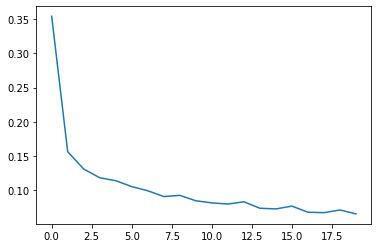

In [6]:
plt.plot(range(20), losses)

In [7]:
correct = 0
total = 0

target_out = []
pred_out = []
with torch.no_grad():
    for (i, data) in enumerate(test_loader):
        input, output = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
        # Predict the class of the image
        input = input.reshape(100, -1)
        outputs = shonkhaObject.forward(input)
        _, predicted = torch.max(outputs.data, 1)

        pred_out += predicted.tolist()
        target_out += output.tolist()


loss_avg = curr_loss / len(train_loader)

acc = accuracy_score(y_true, y_pred)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)


precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)


precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)


perf_metrics = {
    'loss': [loss_avg],
    'accuracy': [acc*100],
    'precision_micro': [precision_micro*100],
    'recall_micro': [recall_micro*100],
    'f1_micro': [f1_micro*100],
    'precision_macro': [precision_macro*100],
    'recall_macro': [recall_macro*100],
    'f1_macro': [f1_macro*100],
    'precision_weighted': [precision_weighted*100],
    'recall_weighted': [recall_weighted*100],
    'f1_weighted': [f1_weighted*100]
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)


,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,0.065817,98.506667,98.506667,98.506667,98.506667,98.501836,98.498835,98.495447,98.523928,98.506667,98.510497
